# Model Project - Markowitz' Portfolio Selection & Extensions
### Introduction to Programming and Numerical Analysis

**University of Copenhagen, 16 May 2021**

Hand-in by Magnus Bugge, Jens Brøndum Petersen & Frederik Bach

## Introduction

In this project, we consider the seminal work of Harry Markowitz (1952), who outlined the foundations for modern portfolio theory. The problem faced is a consumer seeking to maximize the certainty equivalent with a portfolio of financial assets, subject to the constraint that the portfolio weights must sum to 1. Mathematically, this problem is to find an $n\times 1$ weight vector $\omega^*$ that solves: 

$$\omega^*=\max_{\omega\in\mathbb{R}^{n\times 1}, \omega \iota'=1}\omega'\mu - \frac{\gamma}{2}\omega'\Sigma\omega,$$

where $\mu, \Sigma$ are the first two sample moments, respectively, of the joint distribution of returns, and $\gamma$ is a coefficient denoting risk aversion.

The portfolio which solves the maximization problem outlined above is here referred to as the **efficient portfolio**, since it maximizes the expected risk-weighted return, also known as the **Sharpe ratio**. The (annualized) Sharpe ratio, given that the moments are estimated based on the daily returns, is given by 

$$SR=\sqrt{250}\frac{\omega'\mu-r_f}{\sqrt{\omega'\Sigma\omega}},$$

where $r_f$ is the prevailing risk-free rate, which is however assumed to be zero throughout the project.

To summarize, this project estimates the Markowitz portfolio selection problem (with the asset universe given by the Dow Jones Industrial Average). The problem does indeed have a closed-form solution, but we will rely on numerical methods to solve it. Additionally, we consider how the calibration of $\gamma$ affects the optimal portfolio choice, and lastly we backtest a buy-and-hold strategy to illustrate how intertemporal returns distort the portfolio weights and the resulting Sharpe ratios. 

In [1]:
# code block to import necessary packages

# packages for mathematics
import numpy as np
from numpy.linalg import inv,pinv

# packages for data import
import pandas as pd
import pandas_datareader.data as web
import datetime as dt

# packages for numerical optimization
from scipy.optimize import minimize
from scipy import linalg
from scipy.stats import gaussian_kde

# packages for widgets (interactive plots)
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

## Section 1: Data selection, import, and cleansing

The data chosen for this analysis is the universe given by the Dow Jones Industrial Average with daily adjusted closing prices from January 1st 2010 through December 31st 2020. This index consists of 30 constituents, but we have chosen only to include stocks that have been listed throughout the entire sample period. The data is fetched via the Yahoo! Finance API using the *pandas_datareader* package.

In [2]:
# Setting the start and end date for the data imported via the Yahoo! Finance API
start = dt.datetime(2010,1,1)
end = dt.datetime(2020,12,31)

# Specifying the tickers we want prices for (the Dow Jones Industrial Average constituents, incl. the index itself)
tickers = ['^DJI','MMM','AXP','AAPL','BA','CAT','CVX','CSCO','KO','XOM','GS','HD','INTC','IBM','JNJ',
           'JPM','MCD','MRK','MSFT','NKE','PFE','PG','RTX','TRV','UNH','VZ','V','WBA','WMT']

# Specify which API we want to use 
data_source = 'yahoo'

# Get adjusted closing prices (adjusted for dividends etc.) from the tickers of Dow Jones through the Yahoo! Finance API 
prices = web.DataReader(tickers, data_source, start, end)['Adj Close']

Now that we have downloaded all prices into the *prices* table, we need to calculate the daily returns and move the index ticker itself to its own table, such that we can focus on the constituents as possible portfolio investments.

In [3]:
# Calcuate daily returns for all tickers
returns = prices.pct_change()
returns = returns.iloc[1:]

# Save the index return (^DJI) as an individual dataframe, since it is not needed for the portfolio optimization problem
market = returns.iloc[:,0]

# Drops the DJI index column if it has not been dropped already
drop_column = ['^DJI']
returns.drop(drop_column, axis=1, inplace=True)

## Section 2: Data Visualization
Now, we have a table consisting of returns for the 28 stocks considered in this analysis. The following block of code creates an interactive 2 by 2-plot dashboard of various return characteristics. It is possible to choose from 1 to 4 distinct tickers to analyze simultaneously.

In [4]:
# This code  block creates an interactive dashboard that lets the user visualize various characteristics for up to 4 stocks.

def standarddev(stock):
    # calculates a rolling-window estimation of the standard deviation based on the past 252 observations
    std = stock.rolling(window=252).std().dropna()
    return std

x_vals = np.linspace(-0.05,0.05,200)
def DensityPlotting(stock):
    # returns the density function for a given vector of stock returns
    density = gaussian_kde(stock) # Specifying the limits of our data
    density.covariance_factor = lambda : .5 # Smoothing parameter
    density._compute_covariance()
    return density(x_vals)

# A tedious, yet necesary definition to make the dashboard nicer in terms of naming
stocks = [('3M (MMM)', 'MMM'), ('American Express (AXP)', 'AXP'), ('Apple (AAPL)', 'AAPL'), ('Boeing (BA)', 'BA'), 
          ('Caterpillar Inc. (CAT)', 'CAT'),('Chevron Corp. (CVX)','CVX'),('Cisco Systems (CSCO)', 'CSCO'),
          ('The Coca Cola Company (KO)','KO'),('Exxon Mobil (XOM)','XOM'), ('Goldman Sachs (GS)','GS'),
          ('The Home Depot (HD)','HD'),('Intel (INTC)','INTC'),('IBM (IBM)','IBM'),('Johnson & Johnson (JNJ)','JNJ'),
          ('JPMorgan Chase (JPM)','JPM'),('McDonalds (MCD)','MCD'),('Merck & Co. (MRK)','MRK'),('Microsoft (MSFT)','MSFT'),
          ('Nike, Inc. (NKE)','NKE'),('Pfizer (PFE)','PFE'),('Procter & Gamble (PG)','PG'),('Raytheon Technologies Corp (RTX)','RTX'),
          ('The Travelers Companies (TRV)','TRV'),('UnitedHealth Group (UNH)','UNH'),('Verizon Communications (VZ)','VZ'),
          ('VISA (V)','V'),('Walgreens Boots Alliance (WBA)','WBA'),('Walmart (WMT)','WMT')]  

# The actual dashboard code - based on the user choice of "Show", which can take integer values from 1 to 4.
print("\n")
@interact(Show=(1,4))
def ReturnPlot(Show): 
    if Show == 1:
        def onestockreturnplot(Stock): 
            fig, axs = plt.subplots(2, 2, figsize=(14,7))
            axs[0, 0].plot(prices.index, prices[Stock])
            axs[0, 0].set_title("Prices")
            axs[0, 0].legend([Stock])
            axs[1, 0].plot(returns.index, returns[Stock])
            axs[1, 0].set_title("Daily returns")
            axs[1, 0].sharex(axs[0, 0])
            axs[1, 0].legend([Stock])
            axs[0, 1].plot(x_vals,DensityPlotting(returns[Stock]))
            axs[0, 1].set_title("Density of daily returns")
            axs[0, 1].legend([Stock])
            axs[1, 1].plot(standarddev(returns[Stock]).index, standarddev(returns[Stock]))
            axs[1, 1].set_title("Conditional standard deviation")
            axs[1, 1].sharex(axs[0, 0])
            axs[1, 1].legend([Stock])
            fig.tight_layout()
            axs[0, 0].set(ylabel="USD")
            axs[1, 0].set(ylabel="Pct.")
            axs[0, 1].set(ylabel="Density")
        interact(onestockreturnplot, Stock=stocks)
    elif Show == 2:
        def twostocksreturnplot(Stock1, Stock2):
            fig, axs = plt.subplots(2, 2, figsize=(14,7))
            axs[0, 0].plot(prices.index, prices[Stock1])
            axs[0, 0].plot(prices.index, prices[Stock2])
            axs[0, 0].set_title("Prices")
            axs[0, 0].legend([Stock1, Stock2])
            axs[1, 0].plot(returns.index, returns[Stock1])
            axs[1, 0].plot(returns.index, returns[Stock2])
            axs[1, 0].set_title("Daily returns")
            axs[1, 0].sharex(axs[0, 0])
            axs[1, 0].legend([Stock1, Stock2])
            axs[0, 1].plot(x_vals,DensityPlotting(returns[Stock1]))
            axs[0, 1].plot(x_vals,DensityPlotting(returns[Stock2]))
            axs[0, 1].set_title("Density of daily returns")
            axs[0, 1].legend([Stock1, Stock2])
            axs[1, 1].plot(standarddev(returns[Stock1]).index, standarddev(returns[Stock1]))
            axs[1, 1].plot(standarddev(returns[Stock2]).index, standarddev(returns[Stock2]))
            axs[1, 1].set_title("Conditional standard deviation")
            axs[1, 1].sharex(axs[0, 0])
            axs[1, 1].legend([Stock1, Stock2])
            fig.tight_layout()
            axs[0, 0].set(ylabel="USD")
            axs[1, 0].set(ylabel="Pct.")
            axs[0, 1].set(ylabel="Density")
        interact(twostocksreturnplot, Stock1=stocks, Stock2=stocks)
    elif Show == 3:
        def threestocksreturnplot(Stock1, Stock2, Stock3):
            fig, axs = plt.subplots(2, 2, figsize=(14,7))
            axs[0, 0].plot(prices.index, prices[Stock1])
            axs[0, 0].plot(prices.index, prices[Stock2])
            axs[0, 0].plot(prices.index, prices[Stock3])
            axs[0, 0].set_title("Prices")
            axs[0, 0].legend([Stock1, Stock2, Stock3])
            axs[1, 0].plot(returns.index, returns[Stock1])
            axs[1, 0].plot(returns.index, returns[Stock2])
            axs[1, 0].plot(returns.index, returns[Stock3])
            axs[1, 0].set_title("Daily returns")
            axs[1, 0].sharex(axs[0, 0])
            axs[1, 0].legend([Stock1, Stock2, Stock3])
            axs[0, 1].plot(x_vals,DensityPlotting(returns[Stock1]))
            axs[0, 1].plot(x_vals,DensityPlotting(returns[Stock2]))
            axs[0, 1].plot(x_vals,DensityPlotting(returns[Stock3]))
            axs[0, 1].set_title("Density of daily returns")
            axs[0, 1].legend([Stock1, Stock2, Stock3])
            axs[1, 1].plot(standarddev(returns[Stock1]).index, standarddev(returns[Stock1]))
            axs[1, 1].plot(standarddev(returns[Stock2]).index, standarddev(returns[Stock2]))
            axs[1, 1].plot(standarddev(returns[Stock3]).index, standarddev(returns[Stock3]))
            axs[1, 1].set_title("Conditional standard deviation")
            axs[1, 1].sharex(axs[0, 0])
            axs[1, 1].legend([Stock1, Stock2, Stock3])
            fig.tight_layout()
            axs[0, 0].set(ylabel="USD")
            axs[1, 0].set(ylabel="Pct.")
            axs[0, 1].set(ylabel="Density")
        interact(threestocksreturnplot, Stock1=stocks, Stock2=stocks, Stock3=stocks)
    else:
        def fourstocksreturnplot(Stock1, Stock2, Stock3, Stock4):
            fig, axs = plt.subplots(2, 2, figsize=(14,7))
            axs[0, 0].plot(prices.index, prices[Stock1])
            axs[0, 0].plot(prices.index, prices[Stock2])
            axs[0, 0].plot(prices.index, prices[Stock3])
            axs[0, 0].plot(prices.index, prices[Stock4])
            axs[0, 0].set_title("Prices")
            axs[0, 0].legend([Stock1, Stock2, Stock3, Stock4])
            axs[1, 0].plot(returns.index, returns[Stock1])
            axs[1, 0].plot(returns.index, returns[Stock2])
            axs[1, 0].plot(returns.index, returns[Stock3])
            axs[1, 0].plot(returns.index, returns[Stock4])
            axs[1, 0].set_title("Daily returns")
            axs[1, 0].sharex(axs[0, 0])
            axs[1, 0].legend([Stock1, Stock2, Stock3, Stock4])
            axs[0, 1].plot(x_vals,DensityPlotting(returns[Stock1]))
            axs[0, 1].plot(x_vals,DensityPlotting(returns[Stock2]))
            axs[0, 1].plot(x_vals,DensityPlotting(returns[Stock3]))
            axs[0, 1].plot(x_vals,DensityPlotting(returns[Stock4]))
            axs[0, 1].set_title("Density of daily returns")
            axs[0, 1].legend([Stock1, Stock2, Stock3, Stock4])
            axs[1, 1].plot(standarddev(returns[Stock1]).index, standarddev(returns[Stock1]))
            axs[1, 1].plot(standarddev(returns[Stock2]).index, standarddev(returns[Stock2]))
            axs[1, 1].plot(standarddev(returns[Stock3]).index, standarddev(returns[Stock3]))
            axs[1, 1].plot(standarddev(returns[Stock4]).index, standarddev(returns[Stock4]))
            axs[1, 1].set_title("Conditional standard deviation")
            axs[1, 1].sharex(axs[0, 0])
            axs[1, 1].legend([Stock1, Stock2, Stock3, Stock4])
            fig.tight_layout()
            axs[0, 0].set(ylabel="USD")
            axs[1, 0].set(ylabel="Pct.")
            axs[0, 1].set(ylabel="Density")
        interact(fourstocksreturnplot, Stock1=stocks, Stock2=stocks, Stock3=stocks, Stock4=stocks)

interactive(children=(IntSlider(value=2, description='Show', max=4, min=1), Output()), _dom_classes=('widget-i…

# Section 3: Portfolio Optimization
In this section, we solve the portfolio optimization problem that is to find a $n\times 1$ weight vector $\omega^*$ that solves: $$\omega^*=\max_{\omega\in\mathbb{R}^{n\times 1}, \omega \iota'=1}\omega'\mu - \frac{\gamma}{2}\omega'\Sigma\omega,$$
where $\mu, \Sigma$ are the first two sample moments, respectively, of the joint distribution of returns, and $\gamma$ is a coefficient denoting risk aversion.

For simplicty, we use the sample moments as estimators for $\mu$ and $\Sigma$, but a range of other estimators could have been implemented as well. For instance, the Ledoit-Wolf (2003) shrinkage estimator of the covariance matrix $\Sigma$ is robust against the sample covariance being singular. This estimator is widely used across theory and practice, but we will rely on the sample moments to illustrate the more qualitative aspects of model parametrization. 

In addition to the efficient portfolio, that is the solution to the maximization problem shown above, the (extremely) risk-averse investor can also choose the **minimum-variance portfolio**, which by definition is a $n\times 1$ weight vector $\omega^*$ that solves: $$\omega^*=\min_{\omega\in\mathbb{R}^{n\times 1}, \omega \iota'=1}\omega'\Sigma\omega,$$

This portfolio is efficient in the sense that you cannot increase the expected return without taking on additional risk (i.e. a higher expected standard deviation). However, it has a lower Sharpe ratio than the efficient portfolio that maximizes the certainty equivalent.

A first step in the analysis is to estimate the sample moments, which is easily implemented with *numpy* below.

### Section 3.1: Parametrization and Optimization

In [5]:
#Supressing future numpy arrays being printed with a scientific notation.
np.set_printoptions(suppress=True)

#Calculating the expected returns, here defined by mu. 
mu = np.matrix(returns.mean())

#Calculating the covariance matrix, showing the covariances between the respective stocks, with the diagonal being the .
Sigma = np.matrix(returns.cov())

In terms of initial parametrization, we rely myopically on Hautsch et al. (2019) and choose $\gamma=4$. This parameter is to be interpreted as a risk aversity coefficient, and thus a higher $\gamma$ means that an investor has a more concave utilty function. As $\gamma\rightarrow 0$, the investor converges towards being risk-neutral in expected returns.

In [6]:
# initial model parametrization
gamma = 4       # based on Hautsch et al. (2019)
N = len(Sigma)  # number of stocks in the asset universe

In the following code block, we use numerical optimization to compute the two portfolios presented above, i.e. the efficient portfolio (with $\gamma=4$, and the minimum-variance portfolio).

In [7]:
# STEP 1: Define an initial 1/N portfolio used as input for the numerical optimization
w0 = np.full((N, 1), 1/N)

# STEP 2: The efficient portfolio is found by certainty equivalent optimization 
def certainty_equivalent(w,gamma):
    w = np.matrix(w)
    return -(mu @ w.T - gamma/2 * w@Sigma@w.T)[0,0]

# STEP 2.1: Define the leverage constrant (i.e. portfolio weights must sum to 1)
cons1 = ({'type': 'eq', 'fun': lambda x:  np.sum(x)-1.0})

# STEP 2.2: Do the actual optimization
res_eff= minimize(certainty_equivalent, w0, args=gamma, method='SLSQP',constraints=cons1)

# STEP 2.3: The resulting efficient portfolio weights are normalized and stored here
w_eff = res_eff.x/np.sum(res_eff.x )

# STEP 3: The minimum-variance portfolio is found by standard minimization of portfolio variance
def minimum_variance(w):
    w = np.matrix(w)
    return (w@Sigma@w.T)[0,0]

# STEP 3.1: Define the leverage constrant (i.e. portfolio weights must sum to 1)
cons2 = ({'type': 'eq', 'fun': lambda x:  np.sum(x)-1.0})

# STEP 3.2: Do the actual optimization
res_mvp= minimize(minimum_variance, w0, method='SLSQP',constraints=cons2) # does not work, we do it analytically instead.. 

w_mvp = np.array(inv(Sigma)@np.ones(N))[0] # analytical solution

# STEP 3.3: The resulting efficient portfolio weights are normalized and stored here
w_mvp = w_mvp/np.sum(w_mvp)

# STEP 4: Calculate the expected from the two portfolios
print(f'The efficient portfolio yields an expected return of {round((100*mu@w_eff.T)[0,0],3)}%')
print(f'The minimum variance portfolio yields an expected return of {round((100*mu@w_mvp.T)[0,0],3)}%')

The efficient portfolio yields an expected return of 0.257%
The minimum variance portfolio yields an expected return of 0.044%


### Section 3.2: Visualizing the Optimal Portfolios

Now, we have two $n\times 1$ vectors of optimal portfolios weights - one being the efficient portfolio and one being the minimum-variance portfolio. In the following small code block, we visaulize the weight vectors of each portfolio.

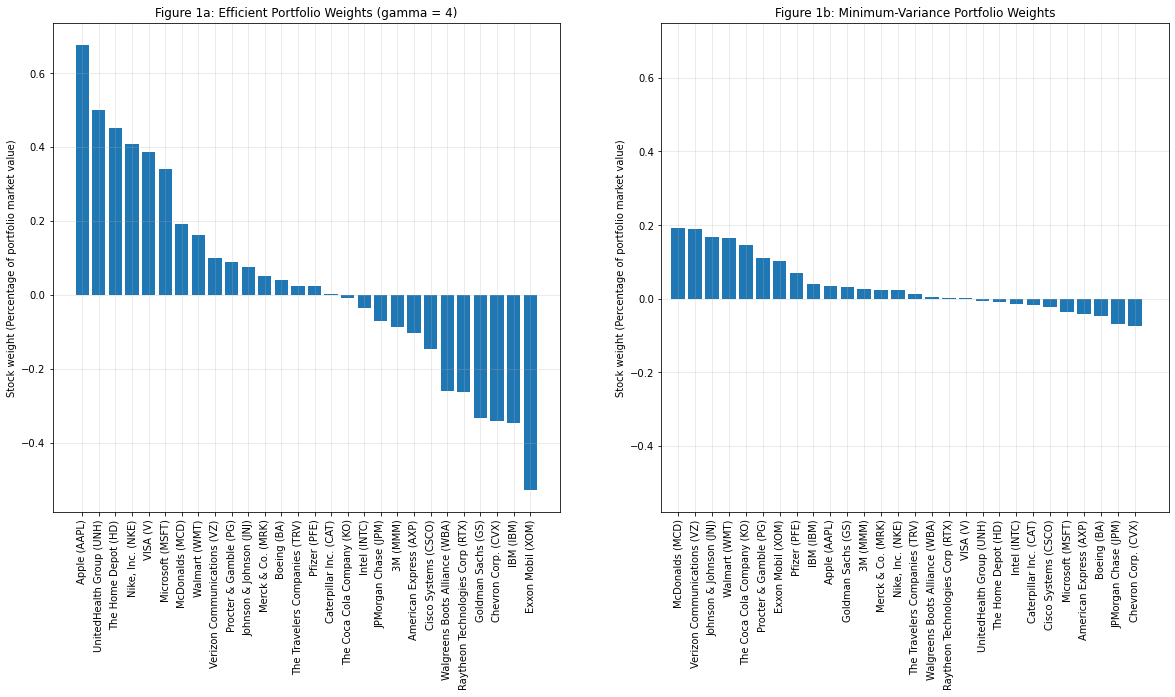

In [8]:
#Converting the tuple of stocks from previous into a array containing only the names of the stocks
stocks_array = np.asarray(stocks)
stocks_array = stocks_array[:,0]

#Making a pandas dataframe to plot, using values calculated and indexing by the stocks_array
w_df = pd.DataFrame(w_eff, index = stocks_array, columns = ["Weight"])
w_df = w_df.sort_values(by = "Weight", ascending=False )

naive_df = pd.DataFrame(w_mvp, index = stocks_array, columns = ["Weight"])
naive_df = naive_df.sort_values(by = "Weight", ascending=False )

#Making a barplot to show weights for a) the efficient portfolio and b) the minimum-variance portfolio
print("\n")
fig = plt.figure(figsize=(20,9))
plt.subplot(1,2,1)
plt.bar(w_df.index, w_df["Weight"])
plt.xticks(rotation=90)
plt.title("Figure 1a: Efficient Portfolio Weights (gamma = 4)")
plt.grid(alpha=0.3)
plt.ylabel("Stock weight (Percentage of portfolio market value)")

plt.subplot(1,2,2)
plt.bar(naive_df.index, naive_df["Weight"])
plt.xticks(rotation=90)
plt.title("Figure 1b: Minimum-Variance Portfolio Weights")
plt.grid(alpha=0.3)
plt.axis([-1, 29, -0.58, 0.75])
plt.ylabel("Stock weight (Percentage of portfolio market value)")
plt.show()

We see from Figures 1a and 1b that the efficient portfolio places relatively extreme weights on some of the assets. For instance, the Apple stock is a long position with a weight of approx. 70% of the entire portfolio market value, while the Exxon Mobil stock is short with approx. 50% of the portfolio market value. Conversely, the minimum-variance portfolio has its highest weight on McDonalds with approx. 18%, which is thereby significantly less concentrated in single names than the efficient portfolio.

Now, we turn to visualizing the so-called *efficient frontier* of risky assets. This is done by constructing a range of convex combinations of the minimum-variance portfolio and the efficient portfolio, since the Two Mutual Fund Theorem proves that any one of such portfolios is an efficient portfolio.

In [9]:
# Here, we define columns for the Pandas dataframe which we will populate with data on the efficient frontier
c = np.linspace(-0.1,1.1,200) # all convex combinations of portfolios
w = np.zeros(200)             # a vector of zeros to be populated with the individual portfolio weights
ret = np.zeros(200)           # a vector of zeros to be populated with the expected return
sd = np.zeros(200)            # a vector of zeros to be populated with the expected risk
sharpe = np.zeros(200)        # a vector of zeros to be populated with the expected Sharpe ration (risk-weighted return)

# Define column names
data = {'w_mvp':  w,
        'w_eff': w,
        'return': ret,
        'sd': sd,
        'sharpe':sharpe}

# Initialize Pandas dataframe
efficient_frontier = pd.DataFrame(data, columns = ['w_mvp','w_eff','return','sd','sharpe'])

# For-loop to iterate through possible combinations of w_eff and w_mvp
for i in range(200):
    efficient_frontier.iat[i,0] = 1-c[i] # weight on the minimum-variance portfolio
    efficient_frontier.iat[i,1] = c[i]   # weight on the efficient portfolio
    port = (1-c[i])*w_mvp + c[i]*w_eff   # convex portfolio combination
    efficient_frontier.iat[i,2] = (mu @ port.T)*250                             # annualized return of the convex combination
    efficient_frontier.iat[i,3] = (np.sqrt(port @ Sigma @ port.T))*np.sqrt(250) # annualized standard deviation of the convex combination
    efficient_frontier.iat[i,4] = ((mu @ port.T) / (np.sqrt(port.T @ Sigma @ port))) * np.sqrt(250) # annualized Sharpe ratio of the conv. comb.
    
# Annualized return and standard deviation for the individual optimal portfolios
eff_port = [250*mu@w_eff.T,np.sqrt(250)*np.sqrt(w_eff.T@Sigma@w_eff)]
mvp_port = [250*mu@w_mvp.T,np.sqrt(250)*np.sqrt(w_mvp.T@Sigma@w_mvp)]

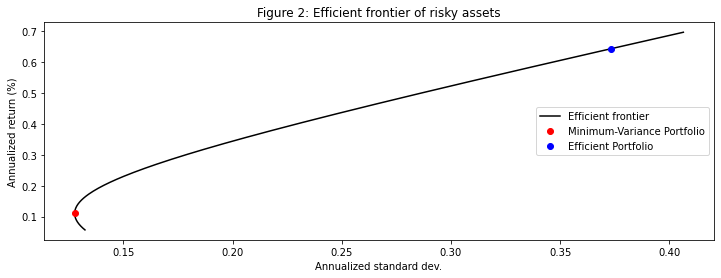

In [10]:
# Here, we plot figure 2, which shows the efficient frontier calculated in the code block above.
print("\n")
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,1,1)
ax.plot(efficient_frontier['sd'],efficient_frontier['return'],'-',color='black',label='Efficient frontier')

ax.plot(mvp_port[1],mvp_port[0],ls='',marker='o',color='red',label='Minimum-Variance Portfolio')
ax.plot(eff_port[1],eff_port[0],ls='',marker='o',color='blue',label='Efficient Portfolio')

ax.set_ylabel('Annualized return (%)')
ax.set_xlabel('Annualized standard dev.')
ax.set_title('Figure 2: Efficient frontier of risky assets')
ax.legend(loc='right');

# Section 4: Extending Markowitz - Alternative Parametrizations and Dynamics

In the following section, we analyze how a different calibration of $\gamma$ would affect the solution to the certainty equivalent maximization procedure. Recall that $\gamma$ denotes a risk aversion coefficient. We construct an interactive plot of the efficient frontier from section 3, where it is possible for the user to change the value of $\gamma$ with a simple slider.

### Section 4.1: Calibration of Investor Risk Aversion

In [35]:
# Here, we define a range of gammas to iterate over. For some reason, the plot breaks down for gamma < 4, so we need to make the first 5 iteration values to be gamma = 4..
gammas = [4, 4, 4, 4, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 16, 18, 19, 20]

# Define an empty array to be populated with the efficient portfolio characteristics based on choice of gamma
eff_port_figa=[]

# Similar to the optimization procedure of section 3, however, with gamma as a variable parameter
for gamma in gammas:
    cons1 = ({'type': 'eq', 'fun': lambda x:  np.sum(x)-1.0})
    res_fig= minimize(certainty_equivalent, w0, args=gamma, method='SLSQP',constraints=cons1)
    w_fig = res_fig.x
    ef_port = [250*mu@w_fig.T,np.sqrt(250)*np.sqrt(w_fig.T@Sigma@w_fig)]
    eff_port_figa.append(ef_port)


# construct interactive plot for different values of gamma 
print("\n")
@interact(gamma_value=(4,20))
def eff_port_def(gamma_value):
    eff_port = eff_port_figa[gamma_value]
    
    fig = plt.figure(figsize=(12,4))

    ax = fig.add_subplot(1,1,1)
    ax.plot(efficient_frontier['sd'],efficient_frontier['return'],'-',color='black',label='Efficient frontier')

    ax.plot(mvp_port[1],mvp_port[0],ls='',marker='o',color='red',label='Minimum Variance')
    ax.plot(eff_port[1],eff_port[0],marker='o',color='blue',label='Efficient Portfolio')

    ax.set_ylabel('Annualized return (%)')
    ax.set_xlabel('Annualized standard dev.')
    ax.set_title('Figure 3: Efficient frontier of risky assets for various degrees of risk aversion')
    ax.legend(loc='right');

interactive(children=(IntSlider(value=12, description='gamma_value', max=20, min=4), Output()), _dom_classes=(…

From Figure 3, one quickly realizes that if the degree of risk aversion increases, the investor will seek a lower risk-weighted return, albeit still being on the efficient frontier. Thus, as $\gamma\rightarrow \infty$, the efficient portfolio converges towards the minimum variance portfolio, since this is the efficient portfolio with the lowest risk-weighted return.

### Section 4.2: Introducing Dynamics to Markowitz
Now, we turn to an extension of the model consideredin, among others, Haustch et al. (2019). The model studied above is static in its nature and does therefore not take into account that the weights of the portfolio will only be constant throughout time if there are no capital gains from holding the portfolio. 

To see this, we illustrate how the Sharpe ratio of holding a given initial portfolio evolves throughout time, if we assume that the portfolio weights are not rebalanced. We perform a backtest of starting 250 days before the last day, where we thus assume that the initial portfolio weight vector is given by $\omega_{i0}=\omega_{eff}$ and $\omega_{i0}=\omega_{mvp}$ for $i=1,2,...,N$. For simplicity, we utilize that sample moments and assume these to be constant throughout time. 

When the investor has an initial portfolio with weights $\omega_{i0}$, the weights in the next period will be given by: $$\omega_{i1}=\omega_{i0}\circ (1+r_{i0}),$$
where $\circ$ denotes element-wise multiplication of returns and weights.

In [12]:
# STEP 1: Define the initial portfolio vectors and calculate the initial risk/return profiles
eff_portfolio = np.array(w_eff)
eff_return = 250*(mu@eff_portfolio.T)[0,0]
eff_sd = np.sqrt(250)*np.sqrt((eff_portfolio.T@ Sigma @ eff_portfolio)[0,0])
print(f'The initial efficient portfolio yields an annualized Sharpe ratio of {round(eff_return/eff_sd,4)}')

mvp_portfolio = np.array(w_mvp) # define the initial portfolio vector
mvp_return = 250*(mu@mvp_portfolio.T)[0,0]
mvp_sd = np.sqrt(250)*np.sqrt((mvp_portfolio.T@ Sigma @ mvp_portfolio)[0,0])
print(f'The initial minimum-variance portfolio yields an annualized Sharpe ratio of {round(mvp_return/mvp_sd,4)}')

The initial efficient portfolio yields an annualized Sharpe ratio of 1.7232
The initial minimum-variance portfolio yields an annualized Sharpe ratio of 0.8621


In [13]:
# STEP 2: Initialize two matrices containing backtesting results
t = np.linspace(0,250,251)
t_ret = np.zeros(251)
t_sd = np.zeros(251)
t_sharpe = np.zeros(251)

bt_col = {'day':  t, 'return': t_ret, 'std. dev.': t_sd, 'Sharpe': t_sharpe}
eff_backtest = pd.DataFrame(bt_col, columns = ['day', 'return','std. dev','Sharpe'])
mvp_backtest = pd.DataFrame(bt_col, columns = ['day', 'return','std. dev','Sharpe'])

# STEP 2.1: Define the backtesting data sample
bt_window = np.matrix(returns[-250:])
    
# STEP 2.2: Define the initial portfolio's characteristics
eff_backtest.iat[0,1] = eff_return
eff_backtest.iat[0,2] = eff_sd
eff_backtest.iat[0,3] = eff_return/eff_sd

mvp_backtest.iat[0,1] = mvp_return
mvp_backtest.iat[0,2] = mvp_sd
mvp_backtest.iat[0,3] = mvp_return/mvp_sd

# STEP 2.3: Create temporary objects for the loop, starting with the initial weights
port_temp_eff = eff_portfolio                      
port_temp_mvp = mvp_portfolio                      
                      
# STEP 3: Backtest a 250-day period where the investor buys and holds a portfolio and simply observes the outcomes ex post
for i in range(1,251):
    # STEP 3.1: Backtesting the non-balancing efficient portfolio
    port_temp_eff = np.multiply(port_temp_eff,(1+bt_window[i-1,:]))
    port_temp_eff = port_temp_eff/np.sum(port_temp_eff)
    eff_backtest.iat[i,1] = 250*(mu@port_temp_eff.T)[0,0]
    eff_backtest.iat[i,2] = np.sqrt(250)*np.sqrt((port_temp_eff@ Sigma @ port_temp_eff.T)[0,0])
    eff_backtest.iat[i,3] = eff_backtest.iat[i,1]/eff_backtest.iat[i,2]
    
    # STEP 3.2: Backtesting the non-balancing minimum-variance portfolio
    port_temp_mvp = np.multiply(port_temp_mvp,(1+bt_window[i-1,:]))
    port_temp_mvp = port_temp_mvp/np.sum(port_temp_mvp)
    mvp_backtest.iat[i,1] = 250*(mu@port_temp_mvp.T)[0,0]
    mvp_backtest.iat[i,2] = np.sqrt(250)*np.sqrt((port_temp_mvp@ Sigma @ port_temp_mvp.T)[0,0])
    mvp_backtest.iat[i,3] = mvp_backtest.iat[i,1]/mvp_backtest.iat[i,2]

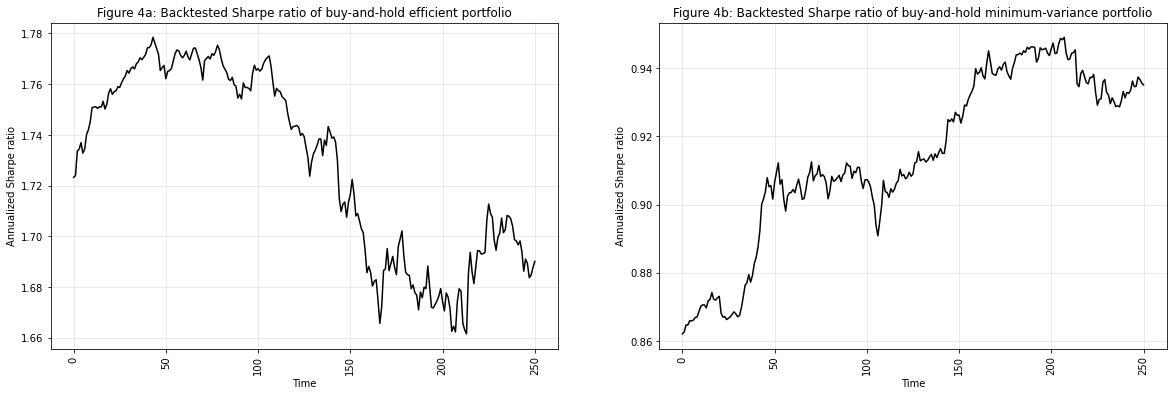

In [14]:
#Making a barplot to show weights for a) the efficient portfolio and b) the minimum-variance portfolio
print("\n")
fig = plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(eff_backtest['day'],eff_backtest['Sharpe'],'-',color='black',label='Annualized Sharpe ratio')
plt.xticks(rotation=90)
plt.title("Figure 4a: Backtested Sharpe ratio of buy-and-hold efficient portfolio")
plt.grid(alpha=0.3)
plt.ylabel("Annualized Sharpe ratio")
plt.xlabel("Time")

plt.subplot(1,2,2)
plt.plot(mvp_backtest['day'],mvp_backtest['Sharpe'],'-',color='black',label='Annualized Sharpe ratio')
plt.xticks(rotation=90)
plt.title("Figure 4b: Backtested Sharpe ratio of buy-and-hold minimum-variance portfolio")
plt.grid(alpha=0.3)
plt.ylabel("Annualized Sharpe ratio")
plt.xlabel("Time")
plt.show()

# Section 4: Concluding remarks

From the analysis above, we conclude that the minimum-variance investor actually improved the Sharpe ratio of the portfolio by buying and holding the portfolio without rebalancing, while the efficient portfolio investor saw a decrease in the Sharpe ratio. Thus, it is crucial for portfolio optimization to consider the dynamics shown above, and to allow rebalancing of the portfolio. However, as shown in Hautsch et al. (2019), rebalancing comes with potentially large transaction costs in the form of broker fees, bid/ask spreads caused by illiquidity etc. Therefore, the investor should include the expected transaction costs of rebalancing in the optimization problem on an ex ante-basis, such that rebalancing only occurs when it improves the cost-adjusted Sharpe ratio of the portfolio.